# Precipitation analysis

Summary of the notebook:
1. Spatiotemporal assessment of precipitation differences
2. Statistical metrics to evaluate dataset performance (Taylor diagram,correlogram)
3. Analysis of WRF experiments as an ensemble

## Import libraries

In [1]:
# Basic libraries
import numpy as np
import xarray as xr
import pandas as pd
import glob
import os

# Plotting libraries
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import seaborn as sn


## Open datasets

Define file paths and name of microphysics schemes

In [2]:
obs_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/'
sim_path = '/media/irene/Elements/wrf_micro/'


In [3]:
schemes = ['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6']


Open datasets

In [22]:
# Reanalysis and observations
ds_prERA = xr.open_dataset(f'{obs_path}/ERA5-pr-acpr-t2m-olr-MCScase.nc')
ds_prIMERG = xr.open_dataset(f'{obs_path}/gpm_PP_mcs20080714-20080724.nc') 
ds_prGLDAS = xr.open_dataset(f'{obs_path}/GLDAS.nc') 
ds_prAPHRO = xr.open_dataset(f'{obs_path}/APHRO_MA_025deg_V1801R1.2008.nc')
ds_prMSWEP = xr.open_dataset(f'{obs_path}/P-MSWEP-MCS.nc') 

# WRF simulations
ds_rpr = {}

for scheme in schemes:
    pattern = os.path.join(sim_path, scheme, 'reg_*_PTO-16to24.nc')
    files = sorted(glob.glob(pattern))
    
    if not files:
        print(f"[WARNING] No files found for: {scheme}")
        continue

    if len(files) == 1:
        ds_rpr[scheme] = xr.open_dataset(files[0])
    else:
        ds_rpr[scheme] = xr.open_mfdataset(files, combine='by_coords', parallel=False)
        

## Cut temporal and spatial domain

Set start and end + days of case study

In [5]:
start = '2008-07-16T00:00:00.000000000'
end = '2008-07-24T23:00:00.000000000'
end_daily = '2008-07-25T00:00:00.000000000' # for daily dataset (APHRODITE)


In [6]:
days = ['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20',
        '2008-07-21','2008-07-22', '2008-07-23', '2008-07-24']


Cut time range (WRF is already cut to the right time range)

In [7]:
ds_prERA = ds_prERA.sel(time=slice(start, end))
ds_prGLDAS = ds_prGLDAS.sel(time=slice(start, end))
ds_prAPHRO = ds_prAPHRO.sel(time=slice(start, end_daily))
ds_prMSWEP = ds_prMSWEP.sel(time=slice(start, end))


Set latitude and longitude + Cut right spatial domain (Sichuan Basin)

In [8]:
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114


In [9]:
# Reanalysis and observations
ds_prERAc = ds_prERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prGLDASc = ds_prGLDAS.sel(lat=slice(lat1-0.2,lat2+0.2), lon=slice(lon1-0.2,lon2+0.2)) #+-0.2 because of spatial resolution of dataset
ds_prAPHROc = ds_prAPHRO.sel(lat=slice(lat1-0.2,lat2+0.2), lon=slice(lon1-0.2,lon2+0.2))
ds_prMSWEPc = ds_prMSWEP.sel(lat=slice(lat2+0.2,lat1-0.2), lon=slice(lon1-0.2,lon2+0.2))

ds_prIMERG['lat'], ds_prIMERG['lon'] = ds_prIMERG.latitude.values, ds_prIMERG.longitude.values # Need this before regridding IMERG
ds_prIMERGc = ds_prIMERG.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2))

# WRF
ds_rprc = {}

for scheme in schemes:
    if scheme in ds_rpr:
        ds_rprc[scheme] = ds_rpr[scheme].sel(latitude=slice(lat2, lat1),longitude=slice(lon1, lon2))
        

Regrid with the nearest neighbour method the observations (WRF is already regridded) to ERA5 horizontal grid

In [10]:
# List ERA5 2D spatial points
lati, longi = ds_prERAc.latitude.values.flatten(), ds_prERAc.longitude.values.flatten()

# Regrid
ds_rprGLDASc =  ds_prGLDASc.sel(lat=lati, lon=longi, method="nearest")
ds_rprAPHROc =  ds_prAPHROc.sel(lat=lati, lon=longi, method="nearest")
ds_rprMSWEPc =  ds_prMSWEPc.sel(lat=lati, lon=longi, method="nearest")
ds_rprIMERGc = ds_prIMERGc.sel(lat=lati, lon=longi, method="nearest")


## Compute precipitation rate and accumulated precipitation time series

Calculate spatial mean of precipitation rate
- *24 to convert mm/hour in mm/day
- *86400 to have in mm/day instead of kg/m2s

In [11]:
# WRF
mean_rpr = {}

for scheme in schemes:
    if scheme in ds_rprc:
        mean_rpr[scheme] = (ds_rprc[scheme].PREC_ACC_NC * 24).mean(dim=('latitude', 'longitude'))

# Observations
mean_prERAc = (ds_prERAc.mtpr*86400).mean(dim=('latitude', 'longitude'))
mean_rprGLDASc = (ds_rprGLDASc.Rainf_f_tavg*86400).mean(dim=('lat', 'lon'))
mean_rprAPHROc = (ds_rprAPHROc.precip).mean(dim=('lat', 'lon'))
mean_rprMSWEPc = (ds_rprMSWEPc.precipitation*8).mean(dim=('lat', 'lon'))


IMERG needs to be handled separately because the dataset structure is different (Time is divided in years, days, hours)

In [12]:
# Cut time + do mean over latitude, longitude + convert to mm/day
mean_rprIMERGc = (ds_prIMERGc['var'][0][2:11]).mean(dim=('lat', 'lon'))*24

# Initialise array to gather all IMERG together
rprIMERGc = np.zeros((9,24))

for m in range(0, 9): #9 days
    for i in range(0, 24):
      rprIMERGc[m][i] = mean_rprIMERGc[m][i];

# Concatenate data for each day to have in one dataset
rprIMERGc = np.concatenate((rprIMERGc[0], rprIMERGc[1], rprIMERGc[2], rprIMERGc[3], rprIMERGc[4], rprIMERGc[5], rprIMERGc[6], rprIMERGc[7], rprIMERGc[8]))


Interpolation of GLDAS and MSWEP to have hourly data instead of every 3 hours

In [13]:
# Set new and old time counters
newtime=np.arange(0,216,1)
oldtime=np.arange(0,216,3)

# Interpolate
new_rprGLDASc = np.interp(newtime, oldtime, mean_rprGLDASc.values)
new_rprMSWEPc = np.interp(newtime, oldtime, mean_rprMSWEPc.values)


Compute daily mean (instead of hourly values) of precipitation rate

In [14]:
# Define groups for WRF
rgroupsc = []

for scheme in schemes:
    if scheme in mean_rpr:
        groups = [mean_rpr[scheme][x:x+24] for x in range(0, len(mean_rpr[scheme]), 24)]
        rgroupsc.append(groups)

# Add Reanalysis and observations
static_datasets = [mean_prERAc, rprIMERGc, new_rprGLDASc, new_rprMSWEPc]

for data in static_datasets:
    groups = [data[x:x+24] for x in range(0, len(data), 24)]
    rgroupsc.append(groups)

# Initialise array
ravgdailyc = np.zeros((len(rgroupsc), 9))  # Now dynamic: 6 model + 4 obs = 10

# Compute daily mean
for m in range(len(rgroupsc)):  # for each dataset
    for i in range(9):  # for each day
        ravgdailyc[m][i] = sum(rgroupsc[m][i]) / 24
        

Compute accumulated precipitation

In [15]:
# Prepare list of datasets: model means (from mean_rpr) + ERA5
ds = [mean_rpr[scheme] / 24 for scheme in schemes if scheme in mean_rpr] + [mean_prERAc / 24]

# Stack all arrays into 2D NumPy array (datasets × time)
data_array = np.array([d.values for d in ds])

# Compute accumulated precipitation with np.cumsum along time axis
racpr = np.cumsum(data_array, axis=1)

# Observational datasets accumulated precipitation
rac_prIMERGc = np.cumsum(rprIMERGc / 24)

racpr_GLDASc = np.cumsum(new_rprGLDASc / 24)

racpr_APHROc = np.cumsum(mean_rprAPHROc)
racpr_APHROc[0] = 0  # APHRO is daily, start at 0

racpr_MSWEPc = np.cumsum(new_rprMSWEPc / 24)


In [16]:
# Select only now the right days because for APHRO accumulated precipitation you use 25 July point (instead of 24T23)
mean_rprAPHROc = mean_rprAPHROc[0:9]


## Compute precipitation rate maps

Compute average over time of precipitation rate for maps

In [17]:
# Mean precipitation rate over XTIME for WRF
meant_rpr = {}

for scheme in schemes:
    if scheme in ds_rprc:
        meant_rpr[scheme] = (ds_rprc[scheme].PREC_ACC_NC * 24).mean(dim='XTIME')

# Observational datasets
meant_prERAc = (ds_prERAc.mtpr * 86400).mean(dim='time')
meant_rprGLDASc = (ds_rprGLDASc.Rainf_f_tavg * 86400).mean(dim='time')
meant_rprAPHROc = (ds_rprAPHROc.precip).mean(dim='time')
meant_rprMSWEPc = (ds_rprMSWEPc.precipitation * 8).mean(dim='time')

meant_rprIMERGc = (ds_rprIMERGc['var'][0][2:11]).mean(dim=('days', 'hours')) * 24
meant_rprIMERGc = meant_rprIMERGc.transpose(transpose_coords=True, missing_dims='raise')


## Plot timeseries of precipitation

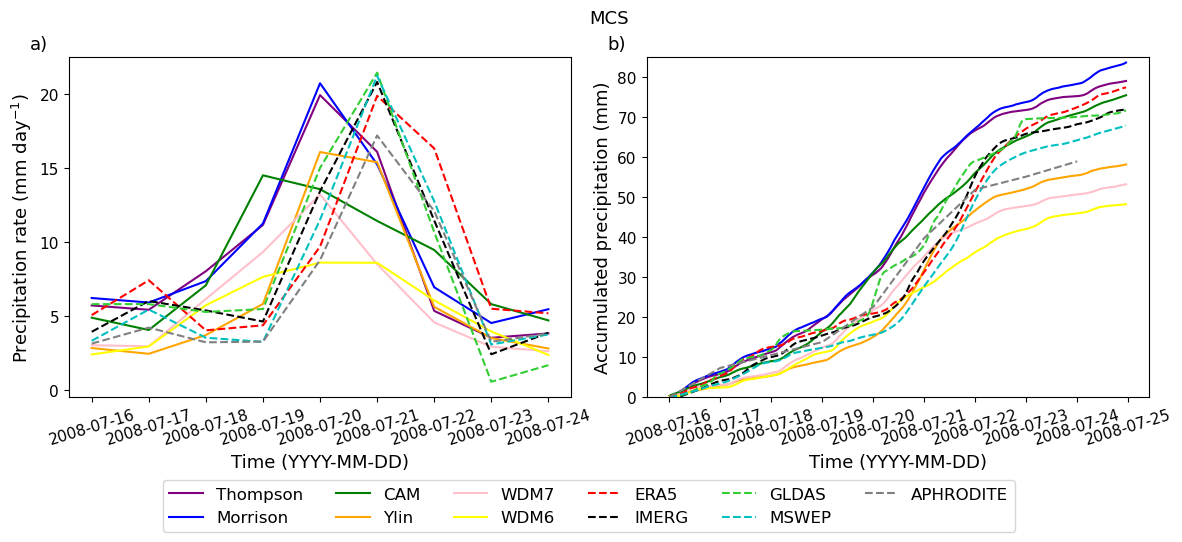

In [24]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.07)

# Define colors for schemes and observations
scheme_colors = ['purple', 'blue', 'green', 'orange', 'pink', 'yellow']
obs_colors = {
    'ERA5': ('r', 'dashed'),
    'IMERG': ('k', 'dashed'),
    'GLDAS': ('limegreen', 'dashed'),
    'MSWEP': ('c', 'dashed'),
    'APHRODITE': ('grey', 'dashed')}

# 1) Precipitation rate plot
for i, scheme in enumerate(schemes):
    axs[0].plot(days, ravgdailyc[i], color=scheme_colors[i], label=scheme)

# Observations (indices after model schemes)
obs_labels = ['ERA5', 'IMERG', 'GLDAS', 'MSWEP']
for j, obs_label in enumerate(obs_labels):
    idx = len(schemes) + j
    color, linestyle = obs_colors[obs_label]
    axs[0].plot(days, ravgdailyc[idx], color=color, linestyle=linestyle, label=obs_label)

# APHRODITE separately (not in ravgdailyc)
axs[0].plot(days, mean_rprAPHROc.values, color=obs_colors['APHRODITE'][0], linestyle=obs_colors['APHRODITE'][1], label='APHRODITE')

axs[0].tick_params(axis='y', labelsize=11)
axs[0].tick_params(axis='x', rotation=17, labelsize=11)
axs[0].set_title('a)', fontsize=13, x=-0.06)
axs[0].set_ylabel(r'Precipitation rate (mm day$^{-1}$)', fontsize=13)
axs[0].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)

# 2) Accumulated precipitation plot
for i, scheme in enumerate(schemes):
    axs[1].plot(ds_prERA.time, racpr[i], color=scheme_colors[i], label=scheme)

# Observations (accumulated)
axs[1].plot(ds_prERA.time, racpr[len(schemes)], color=obs_colors['ERA5'][0], linestyle=obs_colors['ERA5'][1], label='ERA5')
axs[1].plot(ds_prERA.time, rac_prIMERGc, color=obs_colors['IMERG'][0], linestyle=obs_colors['IMERG'][1], label='IMERG')
axs[1].plot(ds_prERA.time, racpr_GLDASc, color=obs_colors['GLDAS'][0], linestyle=obs_colors['GLDAS'][1], label='GLDAS')
axs[1].plot(ds_prERA.time, racpr_MSWEPc, color=obs_colors['MSWEP'][0], linestyle=obs_colors['MSWEP'][1], label='MSWEP')
axs[1].plot(racpr_APHROc.time, racpr_APHROc, color=obs_colors['APHRODITE'][0], linestyle=obs_colors['APHRODITE'][1], label='APHRODITE')

axs[1].legend(loc='upper right', ncol=6, bbox_to_anchor=(0.75, -0.22), fontsize=12)
axs[1].set_ylim(0, 85)
axs[1].tick_params(axis='y', labelsize=11)
axs[1].tick_params(axis='x', rotation=17, labelsize=11)
axs[1].set_title('b)', fontsize=13, x=-0.06)
axs[1].set_ylabel('Accumulated precipitation (mm)', fontsize=13)
axs[1].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.15, hspace=0.25)


plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-time-mcs.png', dpi=400, bbox_inches='tight');

## Plot maps

In [27]:
# Add elevation data to have TP profile
elevation_data =  xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/script/scripts29May/geopotential.nc')
height = elevation_data/9.81
height = height.sel(latitude=slice(35,26), longitude=slice(100,114))

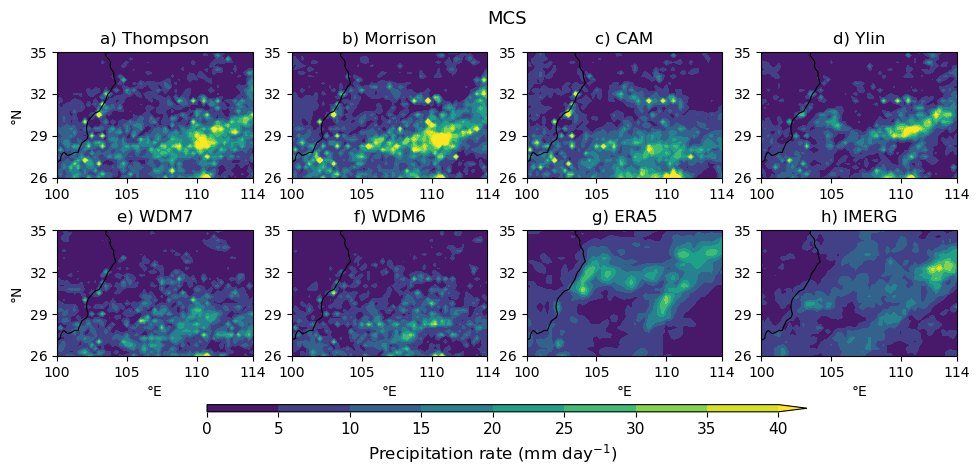

In [31]:
# Datasets and titles
ds = [meant_rpr['Thompson'], meant_rpr['Morrison'], meant_rpr['CAM'], meant_rpr['Ylin'], meant_rpr['WDM7'], meant_rpr['WDM6'], meant_prERAc, meant_rprIMERGc]
titl = ['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5', 'h) IMERG']

# Colormap and contour levels
cmap = plt.cm.viridis
clevs = np.arange(0, 41, 5)

# Create figure with map projections
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.01)

for i in range(len(ds)):
    # Use longitude and latitude from current dataset if available, else fallback to meant_prERAc
    try:
        lon = ds[i].longitude.values
        lat = ds[i].latitude.values
    except AttributeError:
        lon = meant_prERAc.longitude.values
        lat = meant_prERAc.latitude.values
    
    cs = axs[i].contourf(lon, lat, ds[i], levels=clevs, cmap=cmap, extend='max')
    axs[i].contour(height.z.longitude.values, height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
    axs[i].set_title(titl[i], fontsize=12)
    axs[i].set_xticks([100, 105, 110, 114])
    axs[i].set_yticks([26, 29, 32, 35])
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

# Set y-labels and x-labels on specific subplots
axs[0].set_ylabel('°N', fontsize=10)
axs[4].set_ylabel('°N', fontsize=10)
for ax_idx in [4, 5, 6, 7]:
    axs[ax_idx].set_xlabel('°E', fontsize=10)

# Colorbar axis at bottom
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.018])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize=12)
cbar.ax.tick_params(labelsize=11)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-maps-mcs.png', dpi=400, bbox_inches='tight');

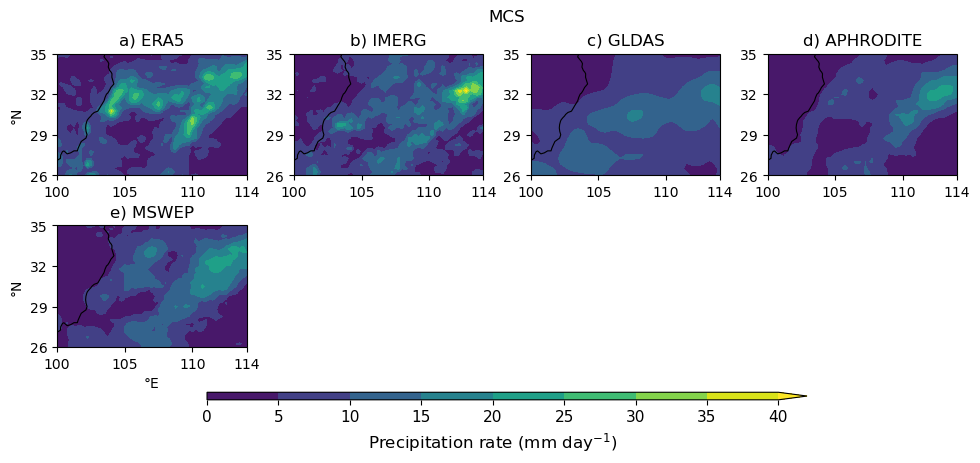

In [35]:
# Observation based and reanalysis datasets
ds = [meant_prERAc, meant_rprIMERGc, meant_rprGLDASc, meant_rprAPHROc, meant_rprMSWEPc]
titl = ['a) ERA5', 'b) IMERG', 'c) GLDAS', 'd) APHRODITE', 'e) MSWEP']

# colormap
cmap = plt.cm.viridis

# set clevels
clevs = np.arange(0, 41, 5)

# create figure
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 4.2))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=12, y=0.98)

# plot each dataset on its axis
for i in range(len(ds)):
    cs = axs[i].contourf(ds[0].longitude.values, ds[0].latitude.values, ds[i], clevs, cmap=cmap, extend='max')
    axs[i].contour(height.z.longitude.values, height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
    axs[i].set_title(titl[i], fontsize=12)
    axs[i].set_xticks([100, 105, 110, 114])
    axs[i].set_yticks([26, 29, 32, 35])
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

# Hide the remaining empty subplots
for j in range(len(ds), len(axs)):
    axs[j].axis('off')

# Add y-label only to the first plot in each row
axs[0].set_ylabel('°N', fontsize=10)
axs[4].set_ylabel('°N', fontsize=10)

# Add x-label only to bottom row subplots
for ax in axs[4:8]:
    ax.set_xlabel('°E', fontsize=10)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.018])  # position at the bottom
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize=12)
cbar.ax.tick_params(labelsize=11)

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95, wspace=0.25, hspace=0.2)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-maps-mcs-appendix.png', dpi=400, bbox_inches='tight');

## Taylor diagram for spatial pattern

In [18]:
# Define Taylor diagram class:
class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

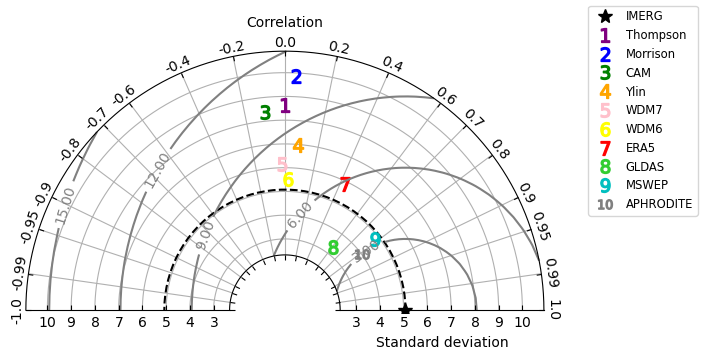

In [19]:
def taylorpr():
    """Display a Taylor diagram"""

    # Reference dataset ERA5
    data = meant_rprIMERGc.values.flatten()
    refstd = data.std(ddof=1)    # Reference standard deviation

    # datasets: WRF simulations and observations
    m1 = meant_rpr['Thompson'].values.flatten()  
    m2 = meant_rpr['Morrison'].values.flatten() 
    m3 = meant_rpr['CAM'].values.flatten()  
    m4 = meant_rpr['Ylin'].values.flatten()
    m5 = meant_rpr['WDM7'].values.flatten()
    m6 = meant_rpr['WDM6'].values.flatten()
    m7 = meant_prERAc.values.flatten()
    m8 = meant_rprGLDASc.values.flatten()
    m9 = meant_rprMSWEPc.values.flatten()
    m10 = meant_rprAPHROc.values.flatten()
    
    # Compute stddev and correlation coefficient of datasets
    samples = np.array([ [m.std(ddof=1), np.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3, m4, m5, m6, m7, m8, m9, m10)])

    fig = plt.figure(figsize=(15, 3.5))

    # dynamic range
    all_stddevs = [m.std(ddof=1) for m in [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]]
    min_std = min(all_stddevs)
    max_std = max(all_stddevs)

    # Add some buffer (20%) around the range
    buffer = 0.2 * refstd

    srange = ((min_std - buffer) / refstd, (max_std + buffer) / refstd)
    
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="IMERG",
                        srange=srange, extend=True)

    colors=['purple', 'blue', 'green', 'orange', 'pink', 'yellow', 'red', 'limegreen', 'c', 'grey']
    datasets=['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6', 'ERA5', 'GLDAS', 'MSWEP', 'APHRODITE']
    
    # Add the datasets to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=datasets[i])

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    
    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


if __name__ == '__main__':

    dia = taylorpr()

## Correlogram for temporal evolution

<Axes: >

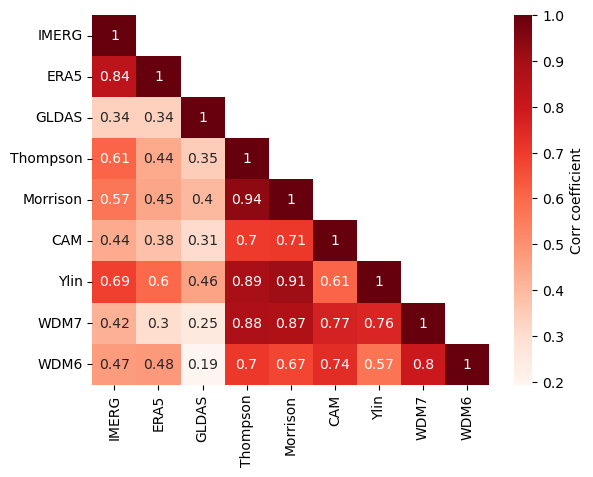

In [20]:
# Datasets
m = rprIMERGc
m0 = mean_prERAc.values
m00 = new_rprGLDASc
m1 = mean_rpr['Thompson'].values 
m2 = mean_rpr['Morrison'].values 
m3 = mean_rpr['CAM'].values  
m4 = mean_rpr['Ylin'].values
m5 = mean_rpr['WDM7'].values
m6 = mean_rpr['WDM6'].values   

# Compute correlation matrix
data = {'IMERG': m, 'ERA5': m0,'GLDAS': m00, 'Thompson': m1, 'Morrison': m2, 'CAM':m3, 'Ylin':m4 , 'WDM7':m5, 'WDM6':m6 }
df = pd.DataFrame(data)
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Want diagonal Elements2 as well
mask[np.diag_indices_from(mask)] = False

# Plot
sn.heatmap(corr_matrix, annot=True, cmap='Reds', mask=mask, cbar_kws={'label': 'Corr coefficient'})

## Precipitation ensemble time series

Set up arrays + compute precipitation rate and accumulated precipitation ensembles

In [41]:
# Assuming all ravgdailyc[i] arrays have the same time axis
time = ds_prERA.time 

# Convert to DataArrays
ravg_das = [xr.DataArray(ravgdailyc[i], dims=['XTIME'], coords={'XTIME': days}) for i in range(6)]

# Concatenate along new 'ensemble' dimension
rpr_ensemble = xr.concat(ravg_das, dim='ensemble')

In [42]:
# Convert to DataArrays
ravg_acdas = [xr.DataArray(racpr[i], dims=['time'], coords={'time': time}) for i in range(6)]

# Concatenate along new 'ensemble' dimension
racpr_ensemble = xr.concat(ravg_acdas, dim='ensemble')

In [43]:
# Compute mean and standard deviation across ensemble
avg_wrf = rpr_ensemble.mean(dim='ensemble')  # ensemble mean at each time step
std_wrf = rpr_ensemble.std(dim='ensemble')   # 1σ spread at each time step

# Get time
time = avg_wrf['XTIME'].values

Plot the time series

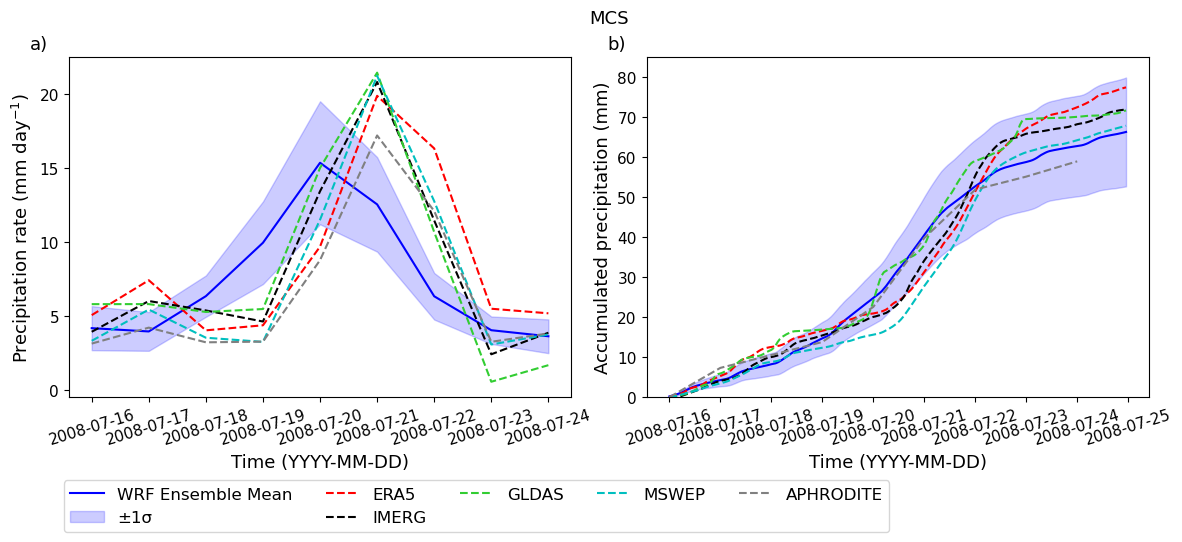

In [45]:
# Time series
nrows, ncols = 1,2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.07)

# Precipitation rate
axs[0].plot(time, avg_wrf, label='WRF Ensemble Mean', color='blue')
axs[0].fill_between(time, avg_wrf - std_wrf, avg_wrf + std_wrf,
                 color='blue', alpha=0.2, label='±1σ')
axs[0].plot(days, ravgdailyc[6], color='r', linestyle='dashed' ,label='ERA5')
axs[0].plot(days, ravgdailyc[7], color='k', linestyle='dashed', label='IMERG')
axs[0].plot(days, ravgdailyc[8], color='limegreen', linestyle='dashed', label='GLDAS')
axs[0].plot(days, ravgdailyc[9], color='c', linestyle='dashed', label='MSWEP')
axs[0].plot(days, mean_rprAPHROc.values, color='grey', linestyle='dashed', label='APHRODITE')

axs[0].tick_params(axis='y', labelsize=11)
axs[0].tick_params(axis='x', rotation=17, labelsize=11)
axs[0].set_title('a)', fontsize=13, x=-0.06)
axs[0].set_ylabel(r'Precipitation rate (mm day$^{-1}$)', fontsize=13)
axs[0].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)


# Accumulated precipitation
plt.plot(actime, acavg_wrf, label='WRF Ensemble Mean', color='blue')
plt.fill_between(actime, acavg_wrf - acstd_wrf, acavg_wrf + acstd_wrf,
                 color='blue', alpha=0.2, label='±1σ')
axs[1].plot(ds_prERA.time, racpr[6], color='r', linestyle='dashed', label='ERA5')
axs[1].plot(ds_prERA.time, rac_prIMERGc, linestyle='dashed',color='k', label='IMERG')
axs[1].plot(ds_prERA.time, racpr_GLDASc, linestyle='dashed',color='limegreen', label='GLDAS')
axs[1].plot(ds_prERA.time, racpr_MSWEPc, linestyle='dashed',color='c', label='MSWEP')
axs[1].plot(racpr_APHROc.time, racpr_APHROc, linestyle='dashed',color='grey', label='APHRODITE')

axs[1].legend(loc='upper right', ncol=5, bbox_to_anchor=(0.5, -0.22), fontsize=12)
axs[1].set_ylim(0, 85)
axs[1].tick_params(axis='y', labelsize=11)
axs[1].tick_params(axis='x', rotation=17, labelsize=11)
axs[1].set_title('b)', fontsize=13, x=-0.06)
axs[1].set_ylabel('Accumulated precipitation (mm)', fontsize=13)
axs[1].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.15, hspace=0.25)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-ens-time-mcs.png', dpi=400, bbox_inches='tight');

## Precipitation ensemble maps

In [51]:
# Mean precipitation rate over XTIME
avgt_wrf = sum(meant_rpr[scheme] for scheme in schemes) / len(schemes)

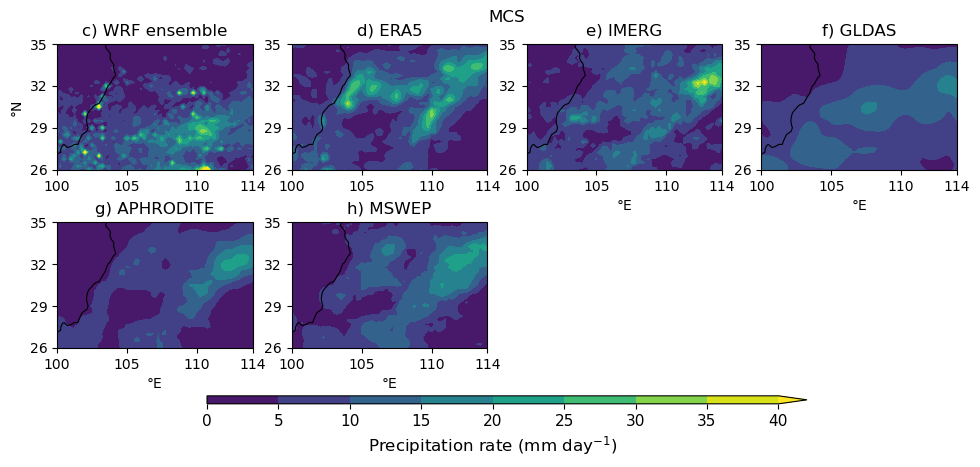

In [52]:
# Observation based and reanalysis datasets
ds = [avgt_wrf, meant_prERAc, meant_rprIMERGc, meant_rprGLDASc, meant_rprAPHROc, meant_rprMSWEPc]
titl=['c) WRF ensemble', 'd) ERA5', 'e) IMERG', 'f) GLDAS', 'g) APHRODITE','h) MSWEP']

#colormap
cmap  = plt.cm.viridis 

#set clevels
clevs=np.arange(0,41,5)

# Create figure
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=12, y=0.99)


# Set maps
for i in range (0, 6):
 cs = axs[i].contourf(ds[0].longitude.values, ds[0].latitude.values, ds[i], clevs, cmap=cmap, extend='max')
 axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
 axs[i].set_title(f'{(3*titl)[i]}', fontsize = 12) 
 axs[i].set_xticks([100,105,110,114])
 axs[i].set_yticks([26,29,32,35])
 axs[i].tick_params(axis='x', labelsize=10)  
 axs[i].tick_params(axis='y', labelsize=10)
 axs[0].set_ylabel('°N', fontsize=10)
 axs[i+2].set_xlabel('°E', fontsize=10)


# Hide the remaining empty subplots
for j in range(len(ds), len(axs)):
    axs[j].axis('off')

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11)
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)